In [160]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [161]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22015 entries, 0 to 22014
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22015 non-null  object 
 1   description               22015 non-null  object 
 2   summary                   22014 non-null  object 
 3   installs                  22015 non-null  object 
 4   minInstalls               22015 non-null  float64
 5   score                     22015 non-null  float64
 6   ratings                   22015 non-null  float64
 7   reviews                   22015 non-null  float64
 8   histogram                 22015 non-null  object 
 9   price                     22015 non-null  float64
 10  free                      22015 non-null  int64  
 11  currency                  22015 non-null  object 
 12  sale                      22015 non-null  bool   
 13  offersIAP                 22015 non-null  bool   
 14  inAppP

In [162]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [163]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [164]:
df = df[df['updated_year'] > 2013]

In [165]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [166]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [167]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

In [168]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [169]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [170]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

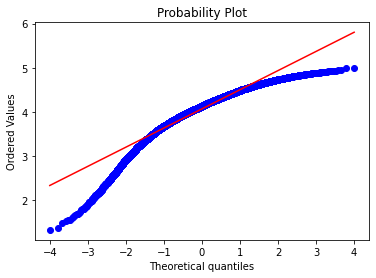

In [171]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 21888
- Mean of distribution of rating : 4.068367483223653
- Standard deviation: 0.4495861122060895


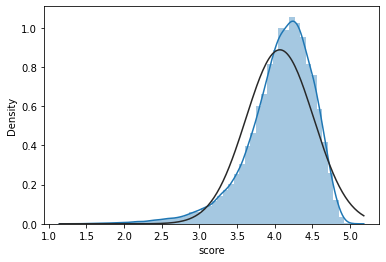

In [172]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

## No pipeline

In [175]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles','genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen']

In [176]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.41
MSE of linear regression on val set: 0.11
MAE of linear regression on val set: 0.25


In [177]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.06
containsAds : 0.01
editorsChoice : 0.07
year : -0.01
top_developer : 0.37
installs_day : 0.00
updated_days : -0.00
has_video : 0.04
compound : 1.16
genre_Adventure : -0.12
genre_Arcade : 0.00
genre_Art & Design : -0.08
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.17
genre_Board : 0.07
genre_Books & Reference : 0.12
genre_Business : 0.10
genre_Card : 0.16
genre_Casino : 0.18
genre_Casual : -0.04
genre_Comics : -0.13
genre_Communication : 0.06
genre_Dating : -0.01
genre_Education : 0.01
genre_Entertainment : -0.04
genre_Events : -0.28
genre_Finance : 0.08
genre_Food & Drink : 0.11
genre_Health & Fitness : 0.12
genre_House & Home : 0.12
genre_Libraries & Demo : -0.07
genre_Lifestyle : -0.01
genre_Maps & Navigation : 0.13
genre_Medical : 0.05
genre_Music & Audio : 0.04
genre_News & Magazines : -0.05
genre_Parenting : 0.06
genre_Personalization : 0.09
genre_Photography : -0.07
genre_Productivity : 0.06
genre_Puzzle : 0.10
genre_Rac

In [178]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [179]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [180]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7955,763222.0,0,0,0,2013,1,362.187613,1204,1,0.297678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.615131,6.997652,2.382521
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.814894,1.963429
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.585394,1.958918
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.811523,1.938100
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.822979,1.807791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13266,50414.0,1,1,0,2016,0,533.049041,19,0,0.081689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.581501,3.811180,-0.770321
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.751591,-0.776710
889,5725.0,1,1,0,2016,0,637.755102,1506,0,-0.140245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.137631,3.354937,-0.782693
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.699171,-0.837594


In [181]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [182]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,21044.171667,0.993333,0.813333,0.003333,2016.276667,0.031667,977.535920,362.643333,0.263333,0.236295,...,0.005000,0.020000,0.008333,0.001667,0.038333,0.050000,0.163333,3.470790,4.019325,0.548534
std,52026.981280,0.081445,0.389969,0.057687,2.433789,0.175257,954.293752,431.667191,0.440809,0.244667,...,0.070593,0.140117,0.090982,0.040825,0.192160,0.218127,0.369978,0.492022,0.380809,0.294554
min,1000.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.647350,0.000000,0.000000,-0.296802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.589474,3.215714,0.263029
25%,3724.000000,1.000000,1.000000,0.000000,2015.000000,0.000000,465.928965,41.000000,0.000000,0.051489,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.212945,3.770404,0.344883
50%,7056.500000,1.000000,1.000000,0.000000,2017.000000,0.000000,668.002970,188.000000,0.000000,0.191675,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.490698,3.941742,0.461299
75%,15854.750000,1.000000,1.000000,0.000000,2018.000000,0.000000,1134.108581,556.250000,1.000000,0.390571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.765762,4.211574,0.650749
max,763222.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,8196.721311,2442.000000,1.000000,0.897580,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.885803,6.997652,2.382521


In [183]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,...,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,22717.403017,0.996767,0.857759,0.009698,2016.191810,0.091595,980.133426,350.581897,0.369612,0.284755,...,0.005388,0.011853,0.010776,0.007543,0.057112,0.044181,0.157328,4.117726,4.115796,-0.001930
std,29441.973782,0.056796,0.349486,0.098054,2.542807,0.288609,941.456226,480.217824,0.482960,0.175994,...,0.073244,0.108285,0.103302,0.086570,0.232182,0.205608,0.364306,0.304522,0.298946,0.058189
min,1023.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,249.875062,0.000000,0.000000,-0.318454,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.363347,3.346604,-0.099914
25%,5586.750000,1.000000,1.000000,0.000000,2014.000000,0.000000,436.300423,30.000000,0.000000,0.178713,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.910612,3.916010,-0.052316
50%,11651.000000,1.000000,1.000000,0.000000,2017.000000,0.000000,677.742664,150.500000,0.000000,0.299085,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.095091,4.095865,-0.003151
75%,26122.250000,1.000000,1.000000,0.000000,2018.000000,0.000000,1112.967090,460.500000,1.000000,0.395106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.312403,4.295248,0.046735
max,244762.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,8695.652174,2564.000000,1.000000,0.886290,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.883638,4.921534,0.099704


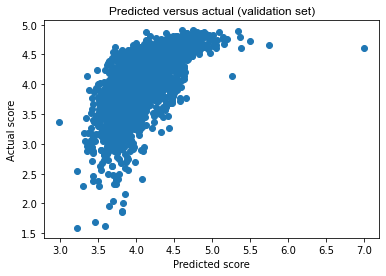

In [184]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

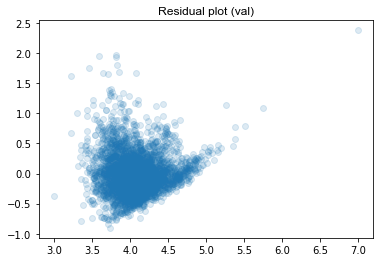

In [185]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing ratings

The sections below iteratively remove features which the model is not using (0.0) or which have very low coefficients. This is to manage for overfitting

In [186]:
features2 = features.copy()
features2.remove('ratings')

In [187]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [188]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.17
year : -0.01
top_developer : 0.46
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.18
genre_Board : 0.06
genre_Books & Reference : 0.11
genre_Business : 0.08
genre_Card : 0.18
genre_Casino : 0.24
genre_Casual : -0.04
genre_Comics : -0.17
genre_Communication : 0.05
genre_Dating : -0.03
genre_Education : -0.02
genre_Entertainment : -0.06
genre_Events : -0.33
genre_Finance : 0.11
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.10
genre_House & Home : 0.10
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.12
genre_Medical : 0.04
genre_Music & Audio : 0.03
genre_News & Magazines : -0.05
genre_Parenting : 0.03
genre_Personalization : 0.07
genre_Photography : -0.09
genre_Productivity : 0.04
genre_Puzzle : 0.12
genre_Racing : -0.02


In [189]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [190]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.881983,2.030519
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.580766,1.954290
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.813389,1.939966
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.908551,1.893363
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.470757,1.773932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9174,35283.0,1,0,0,2019,0,1517.450683,527,0,-0.100061,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.393734,3.609743,-0.783991
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.718232,-0.818532
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.692935,-0.821429
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.766239,-0.864343


## Removing installs / day

In [191]:
features3 = features2.copy()
features3.remove('installs_day')

In [192]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.38
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [193]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.17
year : -0.01
top_developer : 0.46
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.10
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.18
genre_Board : 0.06
genre_Books & Reference : 0.12
genre_Business : 0.07
genre_Card : 0.18
genre_Casino : 0.23
genre_Casual : -0.04
genre_Comics : -0.17
genre_Communication : 0.05
genre_Dating : -0.03
genre_Education : -0.02
genre_Entertainment : -0.06
genre_Events : -0.32
genre_Finance : 0.11
genre_Food & Drink : 0.10
genre_Health & Fitness : 0.10
genre_House & Home : 0.11
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.12
genre_Medical : 0.05
genre_Music & Audio : 0.03
genre_News & Magazines : -0.05
genre_Parenting : 0.03
genre_Personalization : 0.07
genre_Photography : -0.09
genre_Productivity : 0.04
genre_Puzzle : 0.12
genre_Racing : -0.03
genre_Role Playing :

In [194]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [195]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.887946,2.036482
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.811968,1.938545
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.561593,1.935117
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.889604,1.874416
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.477037,1.780212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.737998,-0.790304
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.730314,-0.806451
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.705174,-0.809190
13266,50414.0,1,1,0,2016,0,533.049041,19,0,0.081689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.581501,3.715948,-0.865553


## Removing updated days

In [196]:
features4 = features3.copy()
features4.remove('updated_days')

In [197]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [198]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
year : -0.00
top_developer : 0.46
has_video : 0.07
compound : 1.16
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.17
genre_Board : 0.08
genre_Books & Reference : 0.14
genre_Business : 0.10
genre_Card : 0.19
genre_Casino : 0.25
genre_Casual : -0.03
genre_Comics : -0.15
genre_Communication : 0.06
genre_Dating : -0.00
genre_Education : -0.01
genre_Entertainment : -0.05
genre_Events : -0.30
genre_Finance : 0.14
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.13
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.15
genre_Medical : 0.08
genre_Music & Audio : 0.04
genre_News & Magazines : -0.02
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.08
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping

In [199]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [200]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.887946,2.036482
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.811968,1.938545
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.561593,1.935117
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.889604,1.874416
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.477037,1.780212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.737998,-0.790304
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.730314,-0.806451
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.705174,-0.809190
13266,50414.0,1,1,0,2016,0,533.049041,19,0,0.081689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.581501,3.715948,-0.865553


## Removing year and mature

In [201]:
features5 = features4.copy()
features5.remove('year')
features5.remove('contentRating_Mature 17+')

In [202]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [203]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.10
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.17
genre_Board : 0.08
genre_Books & Reference : 0.15
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.26
genre_Casual : -0.03
genre_Comics : -0.15
genre_Communication : 0.07
genre_Dating : -0.01
genre_Education : 0.00
genre_Entertainment : -0.04
genre_Events : -0.31
genre_Finance : 0.15
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.12
genre_House & Home : 0.14
genre_Libraries & Demo : -0.03
genre_Lifestyle : 0.00
genre_Maps & Navigation : 0.16
genre_Medical : 0.09
genre_Music & Audio : 0.05
genre_News & Magazines : -0.01
genre_Parenting : 0.07
genre_Personalization : 0.08
genre_Photography : -0.07
genre_Productivity : 0.07
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.18
genre_S

In [204]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [205]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.871561,2.020096
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.623386,1.996910
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.771543,1.898121
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845252,1.830064
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.497729,1.800904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.749283,-0.779019
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.712950,-0.801414
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.731721,-0.805043
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.746703,-0.883879


## Removing weather and dating

In [206]:
features6 = features5.copy()
features6.remove('genre_Weather')
features6.remove('genre_Dating')

In [207]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [208]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.10
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.18
genre_Board : 0.08
genre_Books & Reference : 0.14
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.25
genre_Casual : -0.03
genre_Comics : -0.16
genre_Communication : 0.06
genre_Education : -0.00
genre_Entertainment : -0.05
genre_Events : -0.31
genre_Finance : 0.15
genre_Food & Drink : 0.12
genre_Health & Fitness : 0.12
genre_House & Home : 0.14
genre_Libraries & Demo : -0.04
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.15
genre_Medical : 0.09
genre_Music & Audio : 0.04
genre_News & Magazines : -0.01
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.08
genre_Productivity : 0.06
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.06
genre_Shopping : 0.17
genre_Simulation : -0.11
g

In [209]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [210]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.870869,2.019405
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.623135,1.996659
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.771377,1.897954
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845192,1.830003
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.497126,1.800300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.749274,-0.779027
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.745657,-0.791107
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.712067,-0.802297
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.746755,-0.883827


## Removing teen and lifestyle

In [211]:
features7 = features6.copy()
features7.remove('contentRating_Teen')
features7.remove('genre_Lifestyle')

In [212]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [213]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.11
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.17
genre_Board : 0.08
genre_Books & Reference : 0.15
genre_Business : 0.11
genre_Card : 0.20
genre_Casino : 0.24
genre_Casual : -0.03
genre_Comics : -0.16
genre_Communication : 0.07
genre_Education : 0.00
genre_Entertainment : -0.04
genre_Events : -0.30
genre_Finance : 0.16
genre_Food & Drink : 0.13
genre_Health & Fitness : 0.13
genre_House & Home : 0.15
genre_Libraries & Demo : -0.03
genre_Maps & Navigation : 0.16
genre_Medical : 0.09
genre_Music & Audio : 0.05
genre_News & Magazines : -0.01
genre_Parenting : 0.07
genre_Personalization : 0.08
genre_Photography : -0.07
genre_Productivity : 0.07
genre_Puzzle : 0.14
genre_Racing : -0.02
genre_Role Playing : -0.06
genre_Shopping : 0.18
genre_Simulation : -0.11
genre_Social : 0.07
genre_

In [214]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [215]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.870519,2.019054
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.621713,1.995237
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.771763,1.898340
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845265,1.830077
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.490238,1.793413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.747883,-0.780419
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.736135,-0.800630
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.705017,-0.809347
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.742887,-0.887695


## Removing Racing and Art & Design

In [216]:
features8 = features7.copy()
features8.remove('genre_Racing')
features8.remove('genre_Art & Design')

In [217]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [218]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
containsAds : -0.01
editorsChoice : 0.18
top_developer : 0.46
has_video : 0.07
compound : 1.15
genre_Adventure : -0.10
genre_Arcade : 0.03
genre_Auto & Vehicles : 0.13
genre_Beauty : -0.16
genre_Board : 0.09
genre_Books & Reference : 0.16
genre_Business : 0.12
genre_Card : 0.21
genre_Casino : 0.25
genre_Casual : -0.02
genre_Comics : -0.15
genre_Communication : 0.08
genre_Education : 0.01
genre_Entertainment : -0.03
genre_Events : -0.29
genre_Finance : 0.17
genre_Food & Drink : 0.14
genre_Health & Fitness : 0.14
genre_House & Home : 0.16
genre_Libraries & Demo : -0.02
genre_Maps & Navigation : 0.17
genre_Medical : 0.10
genre_Music & Audio : 0.06
genre_News & Magazines : 0.00
genre_Parenting : 0.08
genre_Personalization : 0.09
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Puzzle : 0.15
genre_Role Playing : -0.05
genre_Shopping : 0.19
genre_Simulation : -0.10
genre_Social : 0.08
genre_Sports : 0.02
genre_Strategy : 0.11
genre_Tools :

In [219]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [220]:
check8.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.870575,2.019110
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.622007,1.995531
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.772368,1.898945
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.845499,1.830311
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.480648,1.783822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.747846,-0.780456
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.726226,-0.810539
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.695108,-0.819256
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.742734,-0.887848


## Removing Casual and containsAds

In [221]:
features9 = features8.copy()
features9.remove('genre_Casual')
features9.remove('containsAds')

In [222]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred9))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [223]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.18
top_developer : 0.47
has_video : 0.07
compound : 1.14
genre_Adventure : -0.09
genre_Arcade : 0.04
genre_Auto & Vehicles : 0.14
genre_Beauty : -0.16
genre_Board : 0.09
genre_Books & Reference : 0.17
genre_Business : 0.14
genre_Card : 0.21
genre_Casino : 0.26
genre_Comics : -0.14
genre_Communication : 0.09
genre_Education : 0.02
genre_Entertainment : -0.03
genre_Events : -0.28
genre_Finance : 0.18
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.14
genre_House & Home : 0.17
genre_Libraries & Demo : -0.01
genre_Maps & Navigation : 0.18
genre_Medical : 0.11
genre_Music & Audio : 0.07
genre_News & Magazines : 0.01
genre_Parenting : 0.09
genre_Personalization : 0.10
genre_Photography : -0.06
genre_Productivity : 0.09
genre_Puzzle : 0.15
genre_Role Playing : -0.04
genre_Shopping : 0.20
genre_Simulation : -0.09
genre_Social : 0.09
genre_Sports : 0.03
genre_Strategy : 0.11
genre_Tools : 0.09
genre_Travel & Local : 0.05
genre_T

In [224]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [225]:
check9.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.875220,2.023755
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.625452,1.998976
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.762196,1.888773
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.842981,1.827793
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.479637,1.782811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.608791,-0.778374
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.723862,-0.812903
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.693731,-0.820633
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.745873,-0.884709


## Removing Role playing, Music, Entertainment

In [227]:
features10 = features9.copy()
features10.remove('genre_Role Playing')
features10.remove('genre_Entertainment')

In [228]:
lr10 = LinearRegression()

lr10.fit(X_train[features10], y_train)

y_pred10 = lr10.predict(X_val[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(X_val[features10], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred10))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred10))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [229]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features10].columns, lr10.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.17
top_developer : 0.47
has_video : 0.07
compound : 1.14
genre_Adventure : -0.08
genre_Arcade : 0.05
genre_Auto & Vehicles : 0.15
genre_Beauty : -0.15
genre_Board : 0.10
genre_Books & Reference : 0.18
genre_Business : 0.15
genre_Card : 0.22
genre_Casino : 0.27
genre_Comics : -0.13
genre_Communication : 0.10
genre_Education : 0.03
genre_Events : -0.27
genre_Finance : 0.19
genre_Food & Drink : 0.16
genre_Health & Fitness : 0.16
genre_House & Home : 0.18
genre_Libraries & Demo : -0.00
genre_Maps & Navigation : 0.19
genre_Medical : 0.13
genre_Music & Audio : 0.08
genre_News & Magazines : 0.02
genre_Parenting : 0.10
genre_Personalization : 0.11
genre_Photography : -0.05
genre_Productivity : 0.10
genre_Puzzle : 0.16
genre_Shopping : 0.21
genre_Simulation : -0.08
genre_Social : 0.10
genre_Sports : 0.04
genre_Strategy : 0.12
genre_Tools : 0.10
genre_Travel & Local : 0.06
genre_Trivia : 0.08
genre_Video Players & Editors : -0.03
genr

In [230]:
check10 = X_val.copy()
check10['score'] = y_val
check10['pred'] = lr10.predict(X_val[features10])
check10['resid'] = check10['pred'] - check10['score']

In [231]:
check10.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.875470,2.024006
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.625547,1.999071
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.762287,1.888864
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.843029,1.827841
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.469284,1.772458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.609027,-0.778138
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.713380,-0.823385
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.683484,-0.830880
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.746056,-0.884526


## Removing Libraries & Demo

In [232]:
features11 = features10.copy()
features11.remove('genre_Libraries & Demo')

In [233]:
lr11 = LinearRegression()

lr11.fit(X_train[features11], y_train)

y_pred11 = lr11.predict(X_val[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(X_val[features11], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred11))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred11))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [234]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features11].columns, lr11.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.13
editorsChoice : 0.17
top_developer : 0.47
has_video : 0.07
compound : 1.14
genre_Adventure : -0.08
genre_Arcade : 0.05
genre_Auto & Vehicles : 0.15
genre_Beauty : -0.14
genre_Board : 0.10
genre_Books & Reference : 0.18
genre_Business : 0.15
genre_Card : 0.22
genre_Casino : 0.27
genre_Comics : -0.13
genre_Communication : 0.10
genre_Education : 0.03
genre_Events : -0.27
genre_Finance : 0.19
genre_Food & Drink : 0.16
genre_Health & Fitness : 0.16
genre_House & Home : 0.18
genre_Maps & Navigation : 0.19
genre_Medical : 0.13
genre_Music & Audio : 0.08
genre_News & Magazines : 0.02
genre_Parenting : 0.10
genre_Personalization : 0.11
genre_Photography : -0.05
genre_Productivity : 0.10
genre_Puzzle : 0.16
genre_Shopping : 0.21
genre_Simulation : -0.08
genre_Social : 0.10
genre_Sports : 0.04
genre_Strategy : 0.12
genre_Tools : 0.10
genre_Travel & Local : 0.06
genre_Trivia : 0.08
genre_Video Players & Editors : -0.03
genre_Word : 0.21
contentRating_Eve

In [235]:
check11 = X_val.copy()
check11['score'] = y_val
check11['pred'] = lr11.predict(X_val[features11])
check11['resid'] = check11['pred'] - check11['score']

In [236]:
check11.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
7830,4775.0,1,1,0,2015,0,470.145745,197,1,0.033668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851464,3.875469,2.024004
16322,16079.0,1,1,0,2011,0,298.329356,2442,0,-0.012060,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.626476,3.625541,1.999065
16299,25281.0,1,0,0,2013,0,354.609929,41,0,-0.001986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.762282,1.888859
5639,16293.0,1,0,0,2010,0,267.952840,5,0,-0.010455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015188,3.843026,1.827838
1320,6117.0,1,1,0,2019,0,1430.615165,194,0,-0.171675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.696825,3.469257,1.772431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16211,23706.0,1,0,0,2016,0,583.771162,56,0,-0.103322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.387165,3.609018,-0.778147
16610,9503.0,1,1,0,2017,0,677.048070,4,0,0.042221,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.536765,3.713357,-0.823408
14845,244762.0,1,1,0,2018,0,939.849624,27,1,-0.047502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.514364,3.683462,-0.830902
2985,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.746053,-0.884529


### Test

In [237]:
X_test_cont = X_test[['free','editorsChoice','top_developer','has_video','compound']]

In [238]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [239]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [240]:
y_pred_test = lr11.predict(combo_test_df[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(combo_test_df[features11], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.36
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27


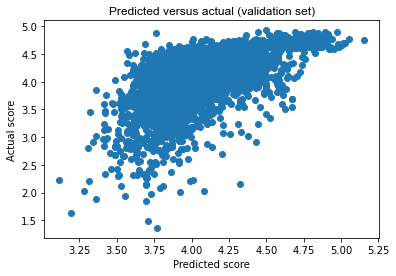

In [241]:
fig, ax = plt.subplots()
plt.scatter(y_pred_test,y_test)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

Great! Model is no longer overfitting